In [1]:
import time
import torch
from torch.distributions import Categorical, kl
from d2l.torch import Animator

from net import Net
from aco import ACO
from utils import *

torch.manual_seed(1234)

lr = 3e-4
EPS = 1e-10
T = 5
device = 'cpu'

In [2]:
def train_instance(model, optimizer, problem_size, n_ants):
    model.train()
    distances, adj_mat, prec_cons = training_instance_gen(problem_size, device)
    pyg_data = gen_pyg_data(distances, adj_mat, device)
    heu_vec = model(pyg_data)
    heu_mat = model.reshape(pyg_data, heu_vec) + EPS
    aco = ACO(
        distances=distances,
        prec_cons=prec_cons,
        n_ants=n_ants,
        heuristic=heu_mat,
        device=device
        )
    costs, log_probs = aco.sample()
    baseline = costs.mean()
    reinforce_loss = torch.sum((costs - baseline) * log_probs.sum(dim=0)) / aco.n_ants
    optimizer.zero_grad()
    reinforce_loss.backward()
    optimizer.step()

def infer_instance(model, problem_size, n_ants):
    model.eval()
    distances, adj_mat, prec_cons = training_instance_gen(problem_size, device)
    pyg_data = gen_pyg_data(distances, adj_mat, device)
    heu_vec = model(pyg_data)
    heu_mat = model.reshape(pyg_data, heu_vec) + EPS
    aco = ACO(
        distances=distances,
        prec_cons=prec_cons,
        n_ants=n_ants,
        heuristic=heu_mat,
        device=device
        )
    costs, log_probs = aco.sample()
    baseline = costs.mean()
    best_sample_cost = torch.min(costs)
    return baseline.item(), best_sample_cost.item()

In [3]:
def train_epoch(n_node,
                n_ants, 
                steps_per_epoch, 
                net, 
                optimizer
                ):
    for _ in range(steps_per_epoch):
        train_instance(net, optimizer, n_node, n_ants)


@torch.no_grad()
def validation(p_size, n_ants, epoch, net, animator=None):
    sum_bl, sum_sample_best = 0, 0
    
    n_val = 50
    for _ in range(n_val):
        bl, sample_best = infer_instance(net, p_size, n_ants)
        sum_bl += bl
        sum_sample_best += sample_best
    
    avg_bl = sum_bl/n_val
    avg_sample_best = sum_sample_best/n_val
    
    if animator:
        animator.add(epoch+1, (avg_bl, avg_sample_best))
    
    return avg_bl, avg_sample_best

In [4]:
def train(n_node, n_ants, steps_per_epoch, epochs):
    net = Net().to(device)
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr)
    animator = Animator(xlabel='epoch', xlim=[0, epochs],
                        legend=["Avg. sample obj.", "Best sample obj."])
    avg_bl, avg_best = validation(n_node, n_ants, -1, net, animator)
    val_results = [(avg_bl, avg_best)]
    
    sum_time = 0
    for epoch in range(0, epochs):
        start = time.time()
        train_epoch(n_node, n_ants, steps_per_epoch, net, optimizer)
        sum_time += time.time() - start
        avg_bl, avg_sample_best = avg_bl, avg_best = validation(n_node, n_ants, epoch, net, animator)
        val_results.append((avg_bl, avg_sample_best))
        
    print('total training duration:', sum_time)
    
    for epoch in range(-1, epochs):
        print(f'epoch {epoch}:', val_results[epoch+1])
        
    torch.save(net.state_dict(), f'../pretrained/sop/sop{n_node}.pt')

Learn heuristic for SOP20: 

total training duration: 24.49080991744995
epoch -1: (18.348251476287842, 16.2952258682251)
epoch 0: (15.65686559677124, 14.171985607147217)
epoch 1: (14.608181858062744, 13.37433095932007)
epoch 2: (14.886593933105468, 13.564254188537598)
epoch 3: (14.717262516021728, 13.488000450134278)
epoch 4: (14.548375968933106, 13.459436721801758)


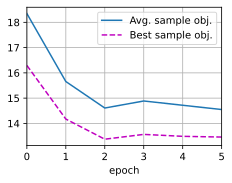

In [5]:
n_node, n_ants = 20, 20
steps_per_epoch = 128
epochs = 5
train(n_node, n_ants, steps_per_epoch, epochs)

Learn heuristic for SOP50:

total training duration: 205.4604082107544
epoch -1: (48.52124671936035, 44.32056938171387)
epoch 0: (38.20186981201172, 35.30699588775635)
epoch 1: (37.508284149169924, 34.88392288208008)
epoch 2: (38.03437805175781, 35.53906112670899)
epoch 3: (37.7853434753418, 35.19153587341309)
epoch 4: (37.647159042358396, 35.10590549468994)


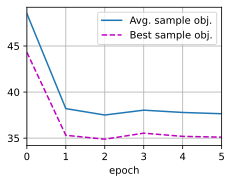

In [6]:
n_node, n_ants = 50, 50
steps_per_epoch = 128
epochs = 5
train(n_node, n_ants, steps_per_epoch, epochs)

Learn heuristic for SOP100

total training duration: 360.63627004623413
epoch -1: (99.0103680419922, 93.04321838378907)
epoch 0: (77.75179641723633, 73.61619659423827)
epoch 1: (75.05592391967774, 71.35157913208008)
epoch 2: (75.96722640991212, 72.10942398071289)
epoch 3: (76.2788328552246, 72.80278167724609)
epoch 4: (76.25512603759766, 72.59599670410157)


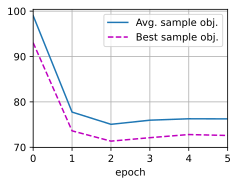

In [7]:
n_node, n_ants = 100, 50
steps_per_epoch = 128
epochs = 5
train(n_node, n_ants, steps_per_epoch, epochs)